# Generate custom template library and recordings with models from the Allen Institute of Brain Science

In this notebook, we show how to build a custom template library using cell models from the Allen Institute database.

In particuar, we downloaded 3 cell models:

- Cell ID [488695444](https://celltypes.brain-map.org/experiment/electrophysiology/488695444) (spiny - excitatory)
- Cell ID [488680211](https://celltypes.brain-map.org/experiment/electrophysiology/488680211) (spiny - excitatory)
- Cell ID [487667205](https://celltypes.brain-map.org/experiment/electrophysiology/487667205) (aspiny - inhibitory)

To get the models, select `Select neuronal model` -> `Biophysical - perisomatic` (or `Biophysical - all active`, if available), download the zip file, and unzip it in a folder with the same name as the cell (e.g. neuronal_model_491623973) in the `allen_models` folder in the working directory. Note that the actual model id might be different than the cell id! In this notebook we assume that the created folder has the model ID (same ID as the downloaded zip).

In [14]:
import numpy as np
import MEArec as mr
import MEAutility as mu
from pathlib import Path
import neuron
import LFPy
import os
import json
import matplotlib.pylab as plt
from pprint import pprint
%matplotlib notebook

## Generating custom templates

We need to define a function to load the cell models in LFPy. The following function takes the cell folder as input, and it returns an `LFPy.Cell` object. 
In order to be used in MEArec to load custom models, the function needs to have the following arguments:

- cell_model_folder: path to cell model folder (str)
- dt: sampling period in s (float)
- start_T: start time of NEURON simulation in s (default 0)
- end_T: end time of NEURON simulation in s (default 1)

In [4]:
# Function to load Allen cells in LFPy
def return_allen_cell(cell_model_folder, dt=2**-5, start_T=0, end_T=1):    
    cell_model_folder = Path(cell_model_folder)
    cwd = os.getcwd()
    os.chdir(cell_model_folder)
    
    # compile mechanisms
    mod_folder = "modfiles"
    os.chdir(mod_folder)
    os.system('nrnivmodl')
    os.chdir('..')
    neuron.load_mechanisms(mod_folder)
    params = json.load(open("fit_parameters.json", 'r'))

    celsius = params["conditions"][0]["celsius"]
    reversal_potentials = params["conditions"][0]["erev"]
    v_init = params["conditions"][0]["v_init"]
    active_mechs = params["genome"]
    neuron.h.celsius = celsius

    cell_parameters = {
        'morphology': 'reconstruction.swc',
        'v_init': v_init,  # initial membrane potential
        'passive': False,  # turn on NEURONs passive mechanism for all sections
        'nsegs_method': 'lambda_f',  # spatial discretization method
        'lambda_f': 200.,  # frequency where length constants are computed
        'dt': dt,  # simulation time step size
        'tstart': start_T,  # start time of simulation, recorders start at t=0
        'tstop': end_T,  # stop simulation at 100 ms.
    }

    cell = LFPy.Cell(**cell_parameters)

    for sec in neuron.h.allsec():
        sec.insert("pas")
        sectype = sec.name().split("[")[0]
        for sec_dict in active_mechs:
            if sec_dict["section"] == sectype:
                # print(sectype, sec_dict)
                if not sec_dict["mechanism"] == "":
                    sec.insert(sec_dict["mechanism"])
                exec ("sec.{} = {}".format(sec_dict["name"], sec_dict["value"]))

        for sec_dict in reversal_potentials:
            if sec_dict["section"] == sectype:
                # print(sectype, sec_dict)
                for key in sec_dict.keys():
                    if not key == "section":
                        exec ("sec.{} = {}".format(key, sec_dict[key]))
    
    os.chdir(cwd)

    return cell

Let's also define a convenient function to plot the projections of the loaded cell.

In [5]:
def plot_cell_projections(cell):
    fig = plt.figure()
    ax_xy = fig.add_subplot(2,2,1)
    ax_xz = fig.add_subplot(2,2,2)    
    ax_yz = fig.add_subplot(2,2,3)    
    
    for i, (xs, xe, ys, ye, zs, ze) in enumerate(zip(cell.xstart, cell.xend, cell.ystart, cell.yend, cell.zstart, cell.zend)):
        if i in cell.get_idx('soma'):
            ax_xy.plot([xs, xe], [ys, ye], color='k', lw=5)
            ax_xz.plot([xs, xe], [zs, ze], color='k', lw=5)
            ax_yz.plot([ys, ye], [zs, ze], color='k', lw=5)
        else:
            ax_xy.plot([xs, xe], [ys, ye], color='k')
            ax_xz.plot([xs, xe], [zs, ze], color='k')
            ax_yz.plot([ys, ye], [zs, ze], color='k')
        
    ax_xy.axis('equal')
    ax_xz.axis('equal')
    ax_yz.axis('equal')
    ax_xy.set_xlabel('x')
    ax_xy.set_ylabel('y')
    ax_xz.set_xlabel('x')
    ax_xz.set_ylabel('z')
    ax_yz.set_xlabel('y')
    ax_yz.set_ylabel('z')

    return fig

First, let's test that the cell model is loaded and run properly by our newly defined function.

In [8]:
cell_folder = 'allen_models/neuronal_model_488462965/'

In [9]:
cell = return_allen_cell(cell_folder)

<IPython.core.display.Javascript object>


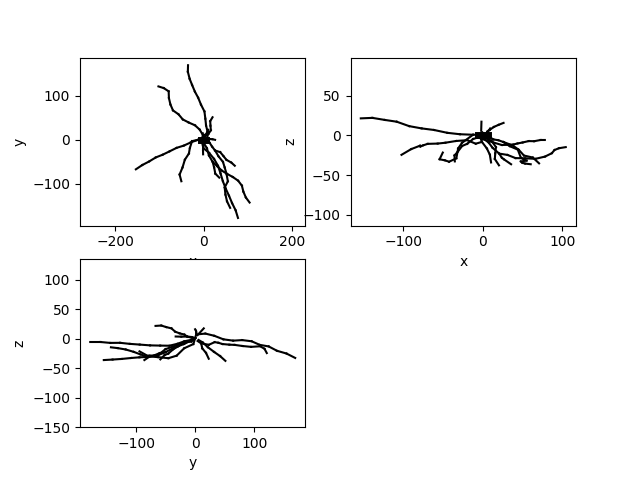

In [10]:
fig = plot_cell_projections(cell)

Great! The cell is loaded properly. Let's now test that the simulation is actually working.
In order to simulate a few spikes that will be used to simulate extracellular action potentials, we can use the `run_cell_model` function. By default, this function runs models from the Blue Brain Project repository, but we can use the `custom_return_cell_function` argument to load and simulate and arbitrary cell model. This function simulates the cell and can return the `LFPy.Cell` object, the somatic membrane potential, and the transmembrane currents for all compartments (when `save` is set to `False`.

We first need to retrieve some parameters for template generation:

In [11]:
template_params = mr.get_default_templates_params()
template_params['seed'] = 0

In [15]:
pprint(template_params)

{'cut_out': [2, 5],
 'delay': 10,
 'drift_steps': 30,
 'drift_xlim': [-10, 10],
 'drift_ylim': [-10, 10],
 'drift_zlim': [20, 80],
 'drifting': False,
 'dt': 0.03125,
 'max_drift': 100,
 'min_amp': 30,
 'min_drift': 30,
 'n': 50,
 'ncontacts': 10,
 'offset': 0,
 'overhang': 30,
 'probe': 'Neuronexus-32',
 'rot': 'physrot',
 'seed': 0,
 'sim_time': 1,
 'target_spikes': [3, 50],
 'weights': [0.25, 1.75],
 'xlim': [10, 80],
 'ylim': None,
 'zlim': None}


In [13]:
cell, v, i = mr.run_cell_model(cell_folder, verbose=True, save=False, 
                               custom_return_cell_function=return_allen_cell, 
                               **template_params)

Mechanisms already loaded from path: modfiles.  Aborting.
Input weight:  0.25  - Num Spikes:  143
Input weight:  0.0625  - Num Spikes:  0
Input weight:  0.109375  - Num Spikes:  0
Input weight:  0.19140625  - Num Spikes:  110
Input weight:  0.0478515625  - Num Spikes:  0
Input weight:  0.083740234375  - Num Spikes:  0
Input weight:  0.14654541015625  - Num Spikes:  36


Let's now plot the the somatic membrane potential and transmembrane current (the soma is compartment 0) for each spike:

<IPython.core.display.Javascript object>


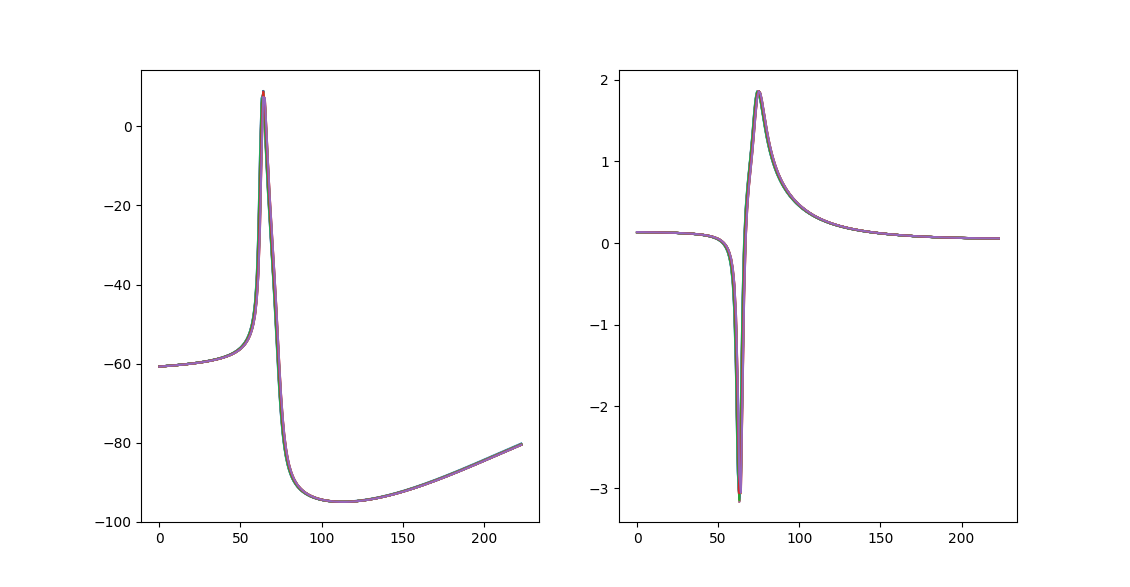

In [17]:
fig = plt.figure()
ax_v = fig.add_subplot(1,2,1)
ax_i = fig.add_subplot(1,2,2)
_ = ax_v.plot(v.T)
_ = ax_i.plot(i[:, 0].T)

### Simulating extracellular action potentials (EAPs)

We have to define other parameters for the extracellular simulation. In this case, we will randomly rotate the cells in 3D and generate 10 templates (at random locations) for each cell model.
Note that the `physrot` rotation is only implemented for BBP models, as it reproduces a specific physiological rotation depending on the cell type.

In [18]:
template_params['rot'] = '3drot'
template_params['n'] = 10

We can choose the probe that we want to use. In this case we'll use the default `Neuronexus-32` probe, with 32 electrodes.

In [19]:
print(template_params['probe'])

Neuronexus-32


In order to list available probes we can use either the `MEAutility` package or the `MEArec` command line interface:

In [20]:
print(mu.return_mea_list())

['2_inline', 'Neuronexus-32', 'Neuropixels-128', 'Neuropixels-24', 'Neuropixels-384', 'Neuropixels-64', 'Neuroseeker-128', 'SqMEA-10-15', 'SqMEA-15-10', 'SqMEA-5-30', 'SqMEA-6-25', 'SqMEA-7-20', 'four-tetrodes', 'monotrode', 'square2x3', 'tetrode', 'tetrode-mea-d', 'tetrode-mea-l', 'tetrode-mea-s']


In [21]:
!mearec available-probes

2_inline ---------- 2 contacts in line.

Neuronexus-32 ---------- Neuronexus A1x32-Poly3-5mm-25s-177-CM32 probe. 32 circular contacts in 3 staggered columns.

Neuropixels-128 ---------- Neuropixels probe. 128 square contacts in 4 staggered columns.

Neuropixels-24 ---------- Neuropixels probe. 24 square contacts in 4 staggered columns.

Neuropixels-384 ---------- Neuropixels probe. 384 square contacts in 4 staggered columns.

Neuropixels-64 ---------- Neuropixels probe. 64 square contacts in 4 staggered columns.

Neuroseeker-128 ---------- Neuroseeker probe. 128 square contacts in 4 columns.

SqMEA-10-15 ---------- Square MEA. 100 square contacts in 10x10 matrix configuration with 15um pitch.

SqMEA-15-10 ---------- Square MEA. 225 square contacts in 15x15 matrix configuration with 10um pitch.

SqMEA-5-30 ---------- Square MEA. 25 square contacts in 5x5 matrix configuration with 30um pitch.

SqMEA-6-25 ---------- Square MEA. 36 square contacts in 6x6 matrix configuration with 25um pitc

The `simulate_templates_one_cell` simulates and returns EAPs, locations of the soma, and rotations applied to each cell before computing the EAP.

In [22]:
eaps, locs, rots = mr.simulate_templates_one_cell(cell_folder, 
                                                  intra_save_folder='allen_sim', params=template_params,
                                                  verbose=True, custom_return_cell_function=return_allen_cell)

Mechanisms already loaded from path: modfiles.  Aborting.
Input weight:  0.25  - Num Spikes:  143
Input weight:  0.0625  - Num Spikes:  0
Input weight:  0.109375  - Num Spikes:  0
Input weight:  0.19140625  - Num Spikes:  110
Input weight:  0.0478515625  - Num Spikes:  0
Input weight:  0.083740234375  - Num Spikes:  0
Input weight:  0.14654541015625  - Num Spikes:  36
Extracellular simulation:  allen_models/neuronal_model_488462965/
3drot
Mechanisms already loaded from path: modfiles.  Aborting.
Cell    extracellular spikes to be simulated


/home/alessiob/.virtualenvs/mearec/lib/python3.6/site-packages/LFPy/recextelectrode.py:317: UserWarning: Membrane currents do not sum to zero
  warnings.warn('Membrane currents do not sum to zero')


Cell:  Progress: [1/10]
Cell:  Progress: [2/10]
Cell:  Progress: [3/10]
Cell:  Progress: [4/10]
Cell:  Progress: [5/10]
Cell:  Progress: [6/10]
Cell:  Progress: [7/10]
Cell:  Progress: [8/10]
Cell:  Progress: [9/10]
Cell:  Progress: [10/10]


The `eaps` have a shape of (n_templates, n_electrodes, n_timepoints). The `locs` and `rots` have a shape of (n_templates, 3).

In [23]:
print(eaps.shape)
print(locs.shape)
print(rots.shape)

(10, 32, 224)
(10, 3)
(10, 3)


### Generating EAPs for all cell models and assembling a template library

We can now loop through all available cell models and build a template library. In order to do that, we also have to provide the cell type, that we can access from the `json` file.

In [24]:
cell_models = [p for p in Path('allen_models/').iterdir()]
print(cell_models)

[PosixPath('allen_models/neuronal_model_489932435'), PosixPath('allen_models/neuronal_model_488462965'), PosixPath('allen_models/neuronal_model_489932682')]


As we now the cell type of the different cells, let's build a dictionary to easily retrieve and save the cell type. At this point, we can choose how we want to characterize excitatory and inhibitory calls. Note that this information will need to be passed to the recording generation phase. For cells from the Allen Institute database we can use "spiny" for exctitatory and "aspiny" for inhibitory:

In [25]:
cell_types = {'488462965': 'spiny', '489932682': 'spiny', '489932435': 'aspiny'}

Let's initialize some variables that will contain our EAPs, locations, rotations, and cell_types:

In [26]:
templates, template_locations, template_rotations, template_celltypes = [], [], [], []

for cell in cell_models:
    eaps, locs, rots = mr.simulate_templates_one_cell(cell_folder, intra_save_folder='allen_sim', 
                                                      params=template_params, verbose=True, 
                                                      custom_return_cell_function=return_allen_cell)
    # find cell type
    cell_type = None
    for k, v in cell_types.items():
        if k in str(cell):
            cell_type = v
            break
    print("Cell", cell, "is", cell_type)
    
    # if first cell, initialize the arrays
    if len(templates) == 0:
        templates = eaps
        template_locations = locs
        template_rotations = rots
        template_celltypes = np.array([cell_type]*len(eaps))
    else:
        templates = np.vstack((templates, eaps))
        template_locations = np.vstack((template_locations, locs))
        template_rotations = np.vstack((template_rotations, rots))
        template_celltypes = np.concatenate((template_celltypes, np.array([cell_type]*len(eaps))))
    




Cell has already be simulated. Using stored membrane currents



Extracellular simulation:  allen_models/neuronal_model_488462965/
3drot
Mechanisms already loaded from path: modfiles.  Aborting.
Cell    extracellular spikes to be simulated
Cell:  Progress: [1/10]
Cell:  Progress: [2/10]
Cell:  Progress: [3/10]
Cell:  Progress: [4/10]
Cell:  Progress: [5/10]
Cell:  Progress: [6/10]
Cell:  Progress: [7/10]
Cell:  Progress: [8/10]
Cell:  Progress: [9/10]
Cell:  Progress: [10/10]
Cell allen_models/neuronal_model_489932435 is aspiny



Cell has already be simulated. Using stored membrane currents



Extracellular simulation:  allen_models/neuronal_model_488462965/
3drot
Mechanisms already loaded from path: modfiles.  Aborting.
Cell    extracellular spikes to be simulated
Cell:  Progress: [1/10]
Cell:  Progress: [2/10]
Cell:  Progress: [3/10]
Cell:  Progress: [4/10]
Cell:  Progress: [5/10]
Cell:  Progress: [6/10]
Cell:  Progress: [7/10]
Cell:  Progress: [8/10]
Cell:  Progress: [9/10]
Cell

In [27]:
print(templates.shape)
print(template_locations.shape)
print(template_rotations.shape)
print(template_celltypes.shape)

(30, 32, 224)
(30, 3)
(30, 3)
(30,)


We can now build a `TemplateGenerator` object that can be stored as an `h5` file and used to simulate recordings. 

We first need to create two dictionaries, `temp_dict` and `info`, containing the templates and related information.

In [36]:
temp_dict = {'templates': templates, 
             'locations': template_locations, 
             'rotations': template_rotations,
             'celltypes': template_celltypes}
info = {}
info['params'] = template_params
info['electrodes'] = mu.return_mea_info(template_params['probe'])

Then we can instantiate a `TemplateGenerator` object. We can alsu use the `MEArec` built-in plot functions to inspect the templates:

In [37]:
tempgen = mr.TemplateGenerator(temp_dict=temp_dict, info=info)

<IPython.core.display.Javascript object>


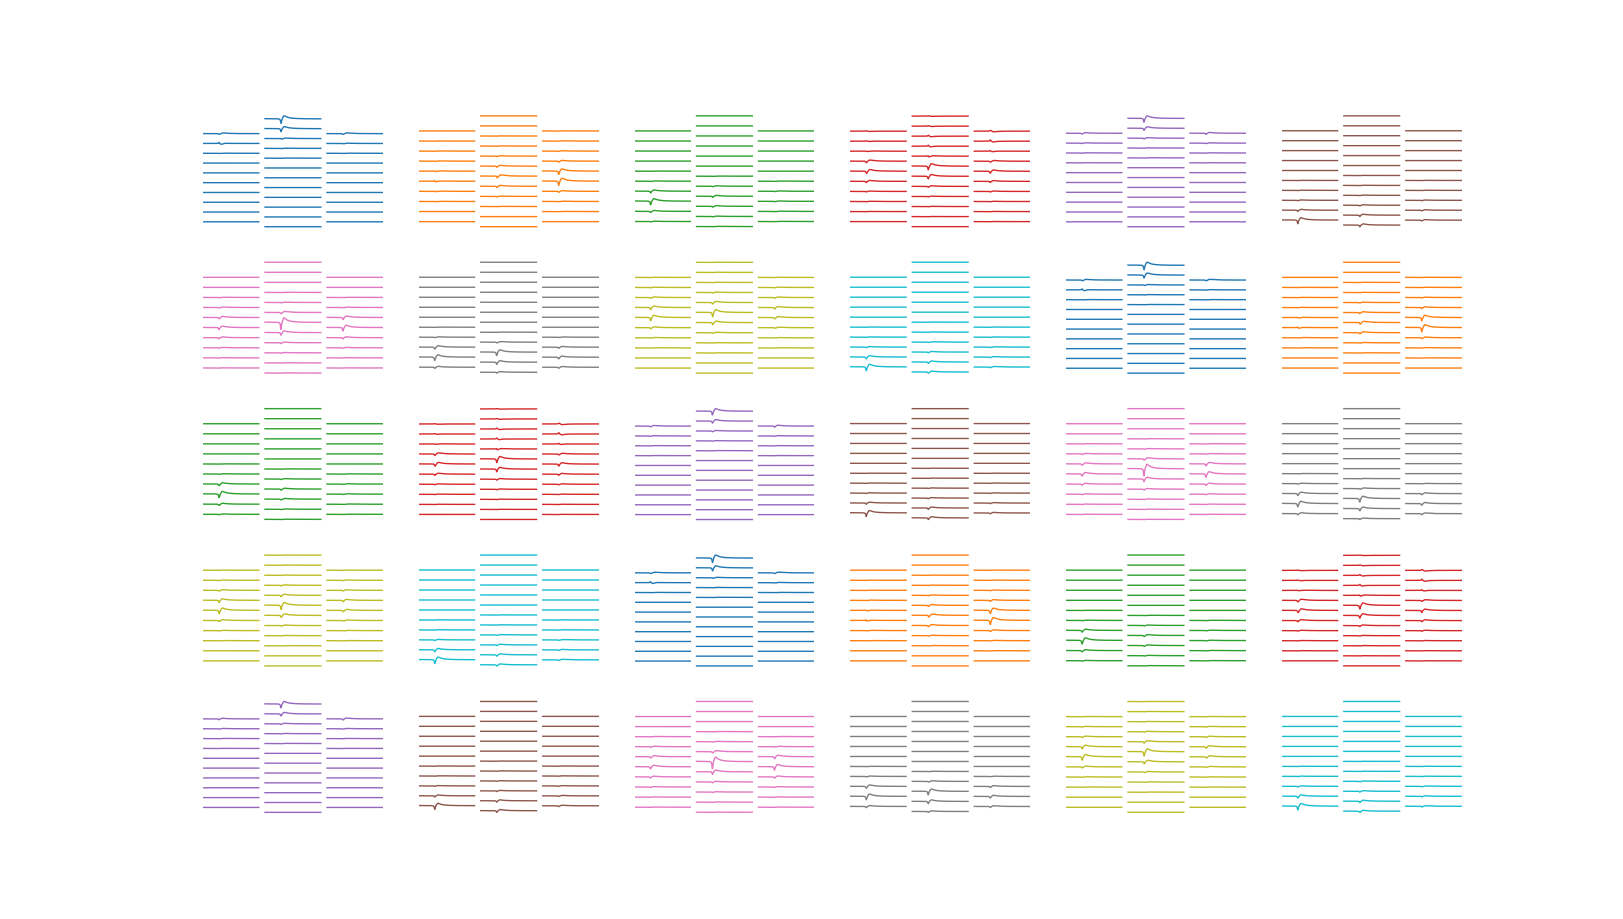

In [31]:
mr.plot_templates(tempgen)

Finally, we can save the template library so that we can easily use it to build recordings:

In [39]:
mr.save_template_generator(tempgen=tempgen, filename='allen/templates_allen.h5')


Saved  templates in allen/templates_allen.h5 



## Generating recordings

We can now use the Allen template library to assemble recordings. In order to do so, we have to change the recording parameters `cell_types` to tell the simulator that "spiny" means excitatory and "aspiny" means inhibitory cells:

In [41]:
rec_params = mr.get_default_recordings_params()
pprint(rec_params)

{'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
                'inhibitory': ['AC',
                               'BP',
                               'BC',
                               'BTC',
                               'ChC',
                               'DBC',
                               'MC',
                               'NGC']},
 'recordings': {'angle_tol': 15,
                'bursting': False,
                'chunk_conv_duration': 20,
                'chunk_filter_duration': 0,
                'chunk_noise_duration': 0,
                'color_noise_floor': 1,
                'color_peak': 300,
                'color_q': 2,
                'drift_velocity': 5,
                'drifting': False,
                'dtype': 'float32',
                'exp_decay': 0.2,
                'extract_waveforms': False,
                'far_neurons_exc_inh_ratio': 0.8,
                'far_neurons_max_amp': 10,
                'far_neurons_n': 300,
                'far_neurons

In [42]:
rec_params['cell_types'] = {'excitatory': ['spiny'], 'inhibitory': ['aspiny']}

Let's now simulate a 30-s recording, with 5 excitatory cells and 2 inhibitory cells. Since we have only 30 templates in total (it's advised to simulate many more templates per cell to be able to generate multiple different recordings), we will reduce the minimum distance between cells to 5um and use a minimum amplitude of 30uV.

In [65]:
rec_params['spiketrains']['duration'] = 30
rec_params['spiketrains']['n_exc'] = 5
rec_params['spiketrains']['n_inh'] = 2
rec_params['templates']['min_dist'] = 5
rec_params['templates']['min_amp'] = 30

In [66]:
recgen = mr.gen_recordings(params=rec_params, templates='allen/templates_allen.h5', verbose=True)

Spiketrains seed:  2462
Noise Level  10
Templates selection seed:  1628
Selecting cells
Selecting random templates (cell types not specified)
Min dist:  5 Min amp:  30
Distance violation 2.5037618207875285 3
Distance violation 0.0 5
Distance violation 2.5037618207875285 7
Distance violation 0.0 9
Distance violation 0.0 10
Distance violation 2.5037618207875285 11
Distance violation 0.0 13
Padding template edges
Elapsed pad time: 0.41118407249450684
Creating time jittering
Elapsed jitter time: 0.45320773124694824
Computing spike train SNR
Adding spiketrain annotations
Electrode modulaton
Splitting in chunks of 20.0 s s
Convolving in:  0.0 s 20.0 s  chunk
Convolving in:  20.0 s 40.0 s  chunk
Starting convolution with spike: 0 shape modulation: False
Starting convolution with spike: 0 shape modulation: False
Done convolution with spike  0
Done convolution with spike  0
Starting convolution with spike: 1 shape modulation: False
Starting convolution with spike: 1 shape modulation: False
Done

Let's now plot the generated spike trains, the selected templates, and the recordings!

<IPython.core.display.Javascript object>


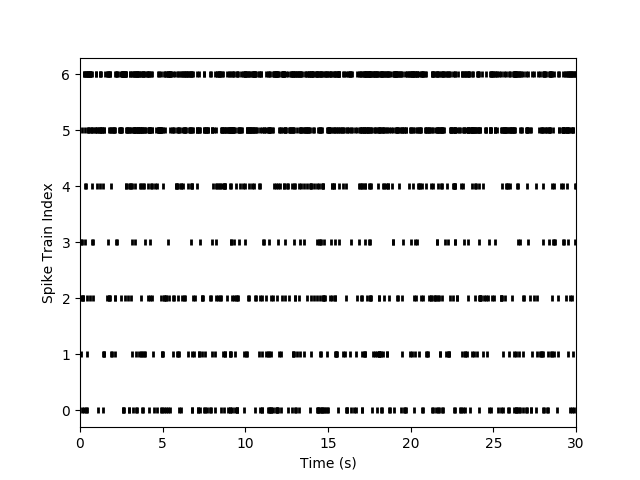

<IPython.core.display.Javascript object>


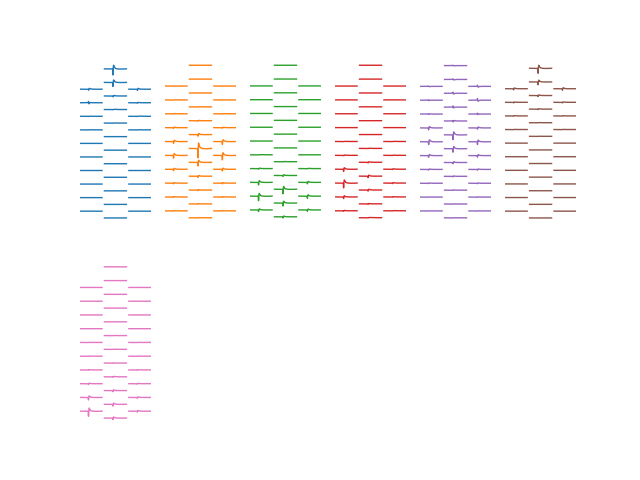

<IPython.core.display.Javascript object>


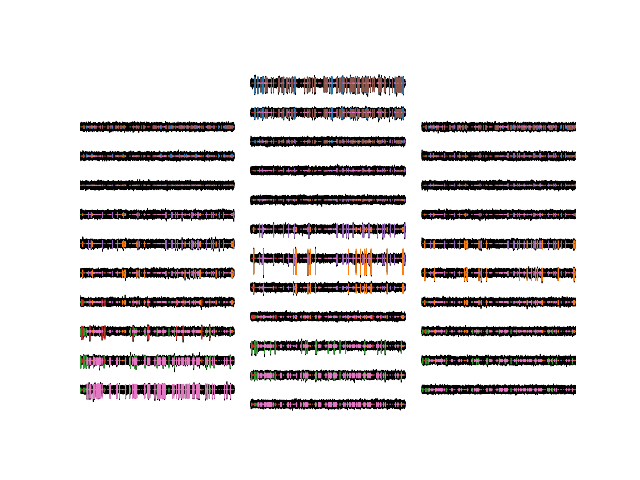

In [70]:
ax_st = mr.plot_rasters(recgen.spiketrains)
ax_temp = mr.plot_templates(recgen)
ax_rec = mr.plot_recordings(recgen, start_time=0, end_time=5, overlay_templates=True, lw=0.5)

Finally, we can save the generated recordings in `h5` format:

In [71]:
mr.save_recording_generator(recgen=recgen, filename='allen/recordings_allen.h5')


Saved recordings in allen/recordings_allen.h5 

